<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Data preprocessinge</h2>
<h3>With explorative graphs</h3>
<h4>IT University of Copenhagen, Spring 2022</h4>
<h4>Group: Nina Sand Horup & Ida Thrane</h4>
</div>

In [1]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, Polygon, LineString

# libraries for plotting
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm



%matplotlib inline
ox.__version__

'1.0.1'

In [44]:
pd.options.mode.chained_assignment = None

# Input parameters

In [2]:
# Plotting parameters

current_position_color = 'red'
food_color = 'magenta' # limegreen
chill_color = 'darkorange'
activity_color = 'blue'

In [3]:
# Edge cost parameters:

no_go_use = 1000
unwanted_use = 6
speed_cost = 4
anti_nature_cost = 4

# Functions

In [4]:
#Change geometries in dataframe to only be points
def gdf_to_only_points(gdf):
    gdf['geometry_init'] = gdf['geometry'] 
    gdf['geometry_init'] = gdf.loc[:, 'geometry']
    
    for i, row in gdf.iterrows():
        if row.geometry.geom_type != "Point":
            new_geometry = row.geometry.centroid
            gdf.at[i, 'geometry'] = new_geometry

In [5]:

# We have the desinations in the form of shapely points and we need the geocoordinates.
def get_coords_from_gdf(gdf):
    geometries =  gdf.geometry
    coords = []
    for geom in geometries: 
        x = geom.x
        y = geom.y
        
        coord = (y,x)
        coords.append(coord)
        
    return coords


# Which OSMIDs do these nodes correspond to, now that we have "simplified" the graph?
# Workaround to use instead of osmnx.distance.nearest_nodes (unavailable in our docker image): 
# https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=digraph#osmnx.distance.nearest_nodes
# here the geodataframe comes in handy for the apply functions:

# Note that these functions are heavily inspired from the exercise 8 solutions


def get_nearest_node(input_coordinate, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)

    distance = nodes.apply(lambda x: np.sqrt((x.y - input_coordinate[0])**2 + (x.x - input_coordinate[1])**2) , axis = 1)
    output = distance.idxmin()
    return output


def get_nearest_nodes(input_coordinates, G):
    nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False, node_geometry=True)
    
    output = []
    for i in range(len(input_coordinates)):
        distances = nodes.apply(lambda x: np.sqrt((x.y - input_coordinates[i][0])**2 + (x.x - input_coordinates[i][1])**2) , axis = 1)
        nearest_node = distances.idxmin()
        output.append(nearest_node)
    return output




In [6]:
# Function to calculate nearest distance to either the big water areas or the big park areas:

def dist_to_nearest_nature(coords, water, parks):
    
    #coords = list(gdf["coordinates"])
    polygons_water = water['geometry']
    polygons_water.reset_index(inplace = True, drop = True)
    
    polygons_parks = parks['geometry']
    polygons_parks.reset_index(inplace = True, drop = True)

    
    # Lists for saving results
    min_distances_to_nature = []
    nature_with_min_dist = []
    nature_type_nearest = []
    
    # Find distance to nearest polygon
    for coord in coords:
        coord = Point(coord[1], coord[0])
        # Water
        dist_to_waters = []
        for poly in polygons_water:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_waters.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_waters.append(distance)
        dist_to_nearest_water = min(dist_to_waters)
        nearest_water = polygons_water[np.argmin(dist_to_waters)]
        
        # Park areas
        dist_to_parks = []
        
        for poly in polygons_parks:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)
                dist_to_parks.append(distance)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)
                dist_to_parks.append(distance)
        dist_to_nearest_park = min(dist_to_parks)
        nearest_park = polygons_parks[np.argmin(dist_to_parks)]
        
        # Both
        dist_to_nearest_nature = min(dist_to_nearest_water, dist_to_nearest_park)
        min_distances_to_nature.append(dist_to_nearest_nature)
        
        if dist_to_nearest_water < dist_to_nearest_park:
            nature_with_min_dist.append(nearest_water)
            nature_type_nearest.append("water")
        else:
            nature_with_min_dist.append(nearest_park)
            nature_type_nearest.append("park")
    
    return min_distances_to_nature, nature_with_min_dist, nature_type_nearest


**Edge cost functions**

In [7]:
def apply_road_use_cost(G, name_of_cost):
    for edge in G.edges:
        if type(G.edges[edge]["highway"]) == str: #meaning we are not dealing with a list
            current_string = G.edges[edge]["highway"]
            if current_string in no_go_road_types:
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * no_go_use
            if current_string in unwanted_road_types:
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * unwanted_use
            else: 
                G.edges[edge][name_of_cost] = 0
        if type(G.edges[edge]["highway"]) == list:
            current_set = set(G.edges[edge]["highway"])
            if current_set.intersection(no_go_road_types):
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * no_go_use
            if current_set.intersection(no_go_road_types):
                G.edges[edge][name_of_cost] = G.edges[edge]["length"] * unwanted_use
            else: 
                G.edges[edge][name_of_cost] = 0


def apply_speed_cost(G, name_of_cost):
    for edge in G.edges:
        if "maxspeed" in G.edges[edge]:
            if (type(G.edges[edge]["maxspeed"]) == list): # Here we take the biggest value, if more than one is listed
                float_list = [float(i) for i in G.edges[edge]["maxspeed"]]
                G.edges[edge][name_of_cost] = max(float_list) * speed_cost
            else: 
                G.edges[edge][name_of_cost] = float(G.edges[edge]["maxspeed"]) * speed_cost
        else:
            G.edges[edge][name_of_cost] = 0


def apply_gain_to_edges_in_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_in_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if coord.within(poly):
                nodes_in_polygons.append(node)
    
    # Apply edge weight to edges with ends in any of these nodes
    for edge in G.edges:
        if (edge[0] in nodes_in_polygons) or (edge[1] in nodes_in_polygons): 
            G.edges[edge][name_of_gain] = 0
        else: 
            G.edges[edge][name_of_gain] = G.edges[edge]["length"] * anti_nature_cost
            
def apply_gain_to_edges_near_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_near_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if poly.geom_type == "Polygon": # Sometimes linestrings are returned, and these cannot be used
                distance = poly.exterior.distance(coord)

                if distance < 0.0005: #If distance is less than 0.5 meters (found empirically to be good)
                    nodes_near_polygons.append(node)
            
            if poly.geom_type == "MultiPolygon":
                single_poly = poly.convex_hull
                distance = single_poly.exterior.distance(coord)

                if distance < 0.0005: #If distance is less than 0.5 meters (found empirically to be good)
                    nodes_near_polygons.append(node)
                
    # Apply edge weight to edges with ends in any of these water nodes
    for edge in G.edges:
        if (edge[0] in nodes_near_polygons) or (edge[1] in nodes_near_polygons): 
            G.edges[edge][name_of_gain] = 0
        else: 
            G.edges[edge][name_of_gain] =  G.edges[edge]["length"]* anti_nature_cost
            
def sum_edge_attributes(G, attributes):
    list_total_costs = []
    for u, v, key, data in G.edges(keys=True, data=True): 
        total_cost = 0
        for att in attributes:
            total_cost = total_cost + data[att]
        data["total_cost"] = total_cost
        list_total_costs.append(total_cost)
    return list_total_costs

**Functions for saving and reloading data**

In [8]:
def graph_cols_to_float(G, cols):
    for i, j, key, data in G.edges(keys = True, data = True):
        for col in cols:
            data[col] = float(data[col])

# Import data

### Import big area

**Network graph**

In [9]:
## Import graph data from folder

G = ox.io.load_graphml("./data/graphs/G_copenhagen")

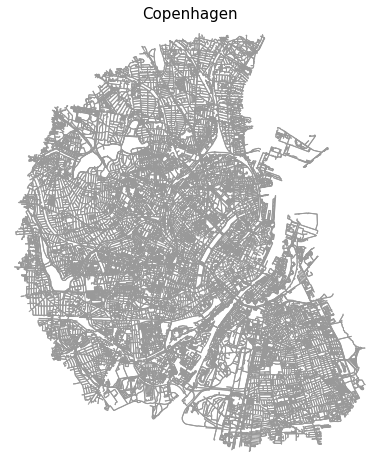

In [10]:
fig, ax = ox.plot_graph(G, node_size=0, show = False, close = False, bgcolor = "white");

ax.set_title("Copenhagen", fontsize = 15)

plt.savefig('./plots/Copenhagen/initial_graph.png')

plt.show()


**Destinations**

In [11]:
#Load Copenhagen data

gdf_cph= gpd.read_file("data/geometries/destinations_copenhagen.json")
gdf_cph=gdf_cph.set_index("id")


**Water areas and parks**

In [12]:
# Import water areas

water = gpd.read_file("data/geometries/water_copenhagen.json")
water=water.set_index("id")
water_polygons = water["geometry"]


In [13]:
# Import parks

parks = gpd.read_file("data/geometries/parks_copenhagen.json")
parks = parks.set_index("id")

parks_polygons = parks["geometry"]

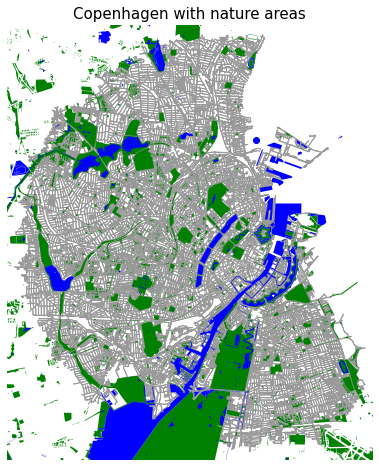

In [14]:
# Plot the water and park areas
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, bgcolor = 'white');

parks.plot(color="green", linewidth=1, ax=ax)

water.plot(color="blue", linewidth=1, ax=ax)

ax.set_title("Copenhagen with nature areas", fontsize = 15)

plt.savefig('./plots/Copenhagen/water_and_parks.png')


# Create subsets of water and park areas


### Calculating water areas and making subset
We create the subsets by calculating the areas (in square-degrees) and setting a threshold.

In [15]:
area_threshold = 2e-6

In [16]:
# Calculate water areas
water_area_list = []
for poly in water_polygons: 
    area = poly.area
    water_area_list.append(area)

# Add the area information back into the geodataframe

water["area"] = water_area_list

In [17]:
# Create water subset
print("min", min(water_area_list),"max",  max(water_area_list),"mean", np.mean(water_area_list))

water_subset = water[water["area"] > area_threshold]


min 0.0 max 0.0006246687872099954 mean 3.175136106275949e-06


In [18]:
# Saving the subset 

with open('data/geometries/water_copenhagen_subset.json', 'w') as f:
    f.write(water_subset.to_json())

### Calculating park areas and making subset


In [19]:

# Calculate park areas
park_area_list = []
for poly in parks_polygons:
    area = poly.area
    park_area_list.append(area)

# Add the area information back into the geodataframe

parks["area"] = park_area_list



In [20]:
# Create park subset 

print("min", min(park_area_list),"max",  max(park_area_list),"mean", np.mean(park_area_list))

parks_subset = parks[parks["area"] > area_threshold]

min 0.0 max 0.003291169249539933 mean 2.67673377620538e-06


In [21]:
# Saving the subset 

with open('data/geometries/parks_copenhagen_subset.json', 'w') as f:
    f.write(parks_subset.to_json())

### Plot

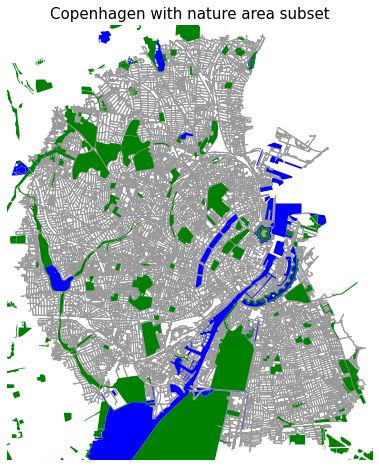

In [22]:
# Plot water subset
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False, bgcolor = 'white');

water_subset.plot(color="blue", linewidth=1, ax=ax)

parks_subset.plot(color="green", linewidth=1, ax=ax)

ax.set_title("Copenhagen with nature area subset", fontsize = 15)

plt.savefig('./plots/Copenhagen/water_parks_subset.png')


# Preprocessing of destinations

In [23]:
#Check for columns only containing nan and drop these
for i in gdf_cph.columns:
    if gdf_cph[i].isnull().values.all() == True:
        gdf_cph = gdf_cph.drop(i, axis=1)


In [24]:
#Find all types of amenities, tourism and leisure in Copenhagen
#print("Unique values in amenity tag Copenhagen", gdf_cph["amenity"].unique())
#print("Unique values in tourism tag Copenhagen", gdf_cph["tourism"].unique())
#print("Unique values in leisure tag Copenhagen", gdf_cph["leisure"].unique())

In [25]:
#Keep only the specific values we want based on the previous list of unique elements

keep_list_a = ['pub', 'restaurant', 'cinema', 'bar', 'nightclub', 'cafe', 'theatre', 'place_of_worship',
                              'ice_cream', 'bicycle_rental', 'flowers', 'fountain', 'arts_centre', 'boat_rental', 'music_venue',
                              'monastery', 'club', 'deli', 'gallery', 'marketplace', 'biergarten', 'food_court', 'planetarium']

keep_list_t = ['picnic_site', 'viewpoint', 'artwork', 'museum', 'gallery', 'theme_park', 'attraction']

keep_list_l = ['bowling_alley', 'trampoline_park', 'adult_gaming_centre',
                              'escape_game', 'garden', 'marina', 'miniature_golf','ceramic_painting',
                              'park', 'dog_park', 'recreation_ground', 'stadium', 'water_park', 
                              'paintball']

#Category lists for later use
food = ['restaurant', 'cafe', 'deli', 'food_court']
after_food = ['pub', 'bar', 'nightclub', 'ice_cream', 'club', 'biergarten']
#A column separating the third category "fun" into three subcategories
cultural = ['place_of_worship', 'arts_centre', 'monastery', 'artwork', 'museum', 'attraction', 'stadium']
activity = ['cinema', 'theatre', 'music_venue', 'gallery', 'planetarium', 
            'theme_park', 'bowling_alley', 'trampoline_park', 'adult_gaming_centre', 
            'escape_game', 'miniature_golf','ceramic_painting', 'water_park', 'paintball']
outdoor = ['bicycle_rental', 'flowers', 'fountain', 'boat_rental', 'marketplace', 'picnic_site', 'viewpoint', 'garden', 
           'marina', 'park', 'dog_park', 'recreation_ground']

#Daytime/nighttime activity
daytime = ['deli', 'ice_cream', 'place_of_worship', 'arts_centre', 
           'monastery', 'gallery', 'planetarium', 'museum', 'theme_park', 
           'bowling_alley', 'trampoline_park', 'adult_gaming_centre', 
           'escape_game', 'miniature_golf','ceramic_painting', 'stadium', 
           'water_park', 'paintball', 'flowers', 'boat_rental', 'marketplace', 
           'picnic_site', 'garden', 'dog_park', 'recreation_ground']
nighttime = ['pub', 'bar', 'nightclub', 'club', 'biergarten','cinema', 'theatre',
            'music_venue', 'bowling_alley']
all_day = ['restaurant', 'cafe', 'food_court', 'attraction', 'bicycle_rental', 'fountain'
           'viewpoint','marina', 'park']

#Copenhagen
gdf_cph_a=gdf_cph[gdf_cph.amenity.isin(keep_list_a)]

gdf_cph_t=gdf_cph[gdf_cph.tourism.isin(keep_list_t)]
        

gdf_cph_l=gdf_cph[gdf_cph.leisure.isin(keep_list_l)]

gdf_cph_all = pd.concat([gdf_cph_a, gdf_cph_t, gdf_cph_l])


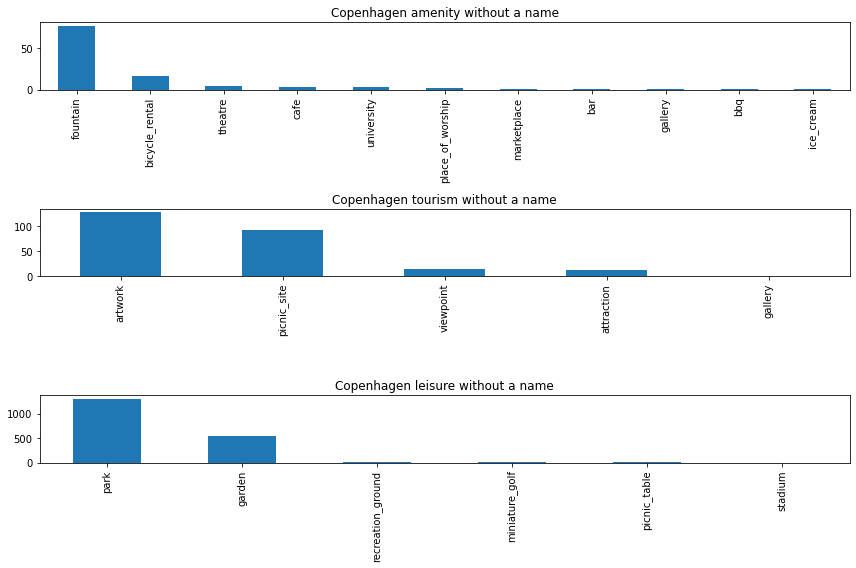

In [26]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]


fig, axs = plt.subplots(3, 1)

gdf_cph_all["amenity"].loc[gdf_cph_all['name'].isnull()].value_counts().plot(ax=axs[0], kind='bar')
axs[0].set_title("Copenhagen amenity without a name")
gdf_cph_all["tourism"].loc[gdf_cph_all['name'].isnull()].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title("Copenhagen tourism without a name")
gdf_cph_all["leisure"].loc[gdf_cph_all['name'].isnull()].value_counts().plot(ax=axs[2], kind='bar')
axs[2].set_title("Copenhagen leisure without a name")

fig.tight_layout()
fig.show()




We find that a lot of the places that do not have a name are sights such as fountains or park, which we want to keep as destination points. On the other hand, we do not wish to keep destinations such as bars and museums which do not have a name. All rows with the column value "service" or "activity" should have a name but "outdoor" does not need to. 

## Data categorization
We want to find certain groups in the data, based on what type of experience, a user could get from the certain destination as we want to propose different types of categories on a route. 
We will divide the categories into:
- The service industry (including destinations such as bars and restaurants)
- Cultural destinations (such as museums and galleries)
- Outdoor destinations (such as parks and fountains)

We also split the data time category based on their opening hours.

First we look into the unique values of each tag and qualitatively assign these to one of the three categories 

In [27]:
#print(gdf_cph_all["amenity"].unique())
#print(gdf_cph_all["tourism"].unique())
#print(gdf_cph_all["leisure"].unique())

In [66]:
#Dropping Na for service and activity
#food
gdf_cph_new_food_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(food)]
gdf_cph_new_food_amenity['category'] = "food"
gdf_cph_new_food_amenity=gdf_cph_new_food_amenity.dropna(subset=['name'])

gdf_cph_new_food_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(food)]
gdf_cph_new_food_tourism['category'] = "food"
gdf_cph_new_food_tourism=gdf_cph_new_food_tourism.dropna(subset=['name'])

gdf_cph_new_food_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(food)]
gdf_cph_new_food_leisure['category'] = "food"
gdf_cph_new_food_leisure=gdf_cph_new_food_leisure.dropna(subset=['name'])

#after food
gdf_cph_new_after_food_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(after_food)]
gdf_cph_new_after_food_amenity['category'] = "after_food"
gdf_cph_new_after_food_amenity=gdf_cph_new_after_food_amenity.dropna(subset=['name'])

gdf_cph_new_after_food_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(after_food)]
gdf_cph_new_after_food_tourism['category'] = "after_food"
gdf_cph_new_after_food_tourism=gdf_cph_new_after_food_tourism.dropna(subset=['name'])

gdf_cph_new_after_food_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(after_food)]
gdf_cph_new_after_food_leisure['category'] = "after_food"
gdf_cph_new_after_food_leisure=gdf_cph_new_after_food_leisure.dropna(subset=['name'])

#activity
gdf_cph_new_activity_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(activity)]
gdf_cph_new_activity_amenity['category'] = "activity"
gdf_cph_new_activity_amenity=gdf_cph_new_activity_amenity.dropna(subset=['name'])

gdf_cph_new_activity_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(activity)]
gdf_cph_new_activity_tourism['category'] = "activity"
gdf_cph_new_activity_tourism=gdf_cph_new_activity_tourism.dropna(subset=['name'])

gdf_cph_new_activity_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(activity)]
gdf_cph_new_activity_leisure['category'] = "activity"
gdf_cph_new_activity_leisure=gdf_cph_new_activity_leisure.dropna(subset=['name'])

#cultural
gdf_cph_new_cultural_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(cultural)]
gdf_cph_new_cultural_amenity['category'] = "cultural"
gdf_cph_new_cultural_amenity=gdf_cph_new_cultural_amenity.dropna(subset=['name'])

gdf_cph_new_cultural_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(cultural)]
gdf_cph_new_cultural_tourism['category'] = "cultural"
gdf_cph_new_cultural_tourism=gdf_cph_new_cultural_tourism.dropna(subset=['name'])

gdf_cph_new_cultural_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(cultural)]
gdf_cph_new_cultural_leisure['category'] = "cultural"
gdf_cph_new_cultural_leisure=gdf_cph_new_cultural_leisure.dropna(subset=['name'])

#outdoor
gdf_cph_new_outdoor_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(outdoor)]
gdf_cph_new_outdoor_amenity['category'] = "outdoor"

gdf_cph_new_outdoor_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(outdoor)]
gdf_cph_new_outdoor_tourism['category'] = "outdoor"

gdf_cph_new_outdoor_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(outdoor)]
gdf_cph_new_outdoor_leisure['category'] = "outdoor"

#Put them all together
dataframes =[gdf_cph_new_food_amenity, gdf_cph_new_food_tourism, gdf_cph_new_food_leisure,
             gdf_cph_new_after_food_amenity, gdf_cph_new_after_food_tourism, gdf_cph_new_after_food_leisure,
             gdf_cph_new_activity_amenity,gdf_cph_new_activity_tourism, gdf_cph_new_activity_leisure,
             gdf_cph_new_cultural_amenity,gdf_cph_new_cultural_tourism, gdf_cph_new_cultural_leisure,
             gdf_cph_new_outdoor_amenity, gdf_cph_new_outdoor_tourism, gdf_cph_new_outdoor_leisure]
gdf_cph_all = pd.concat(dataframes)


In [29]:
gdf_cph_new_daytime_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(daytime)]
gdf_cph_new_daytime_amenity['time'] = "daytime"

gdf_cph_new_nighttime_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(nighttime)]
gdf_cph_new_nighttime_amenity['time'] = "nighttime"

gdf_cph_new_all_day_amenity=gdf_cph_all[gdf_cph_all['amenity'].isin(all_day)]
gdf_cph_new_all_day_amenity['time'] = "all_day"

gdf_cph_new_daytime_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(daytime)]
gdf_cph_new_daytime_tourism['time'] = "daytime"

gdf_cph_new_nighttime_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(nighttime)]
gdf_cph_new_nighttime_tourism['time'] = "nighttime"

gdf_cph_new_all_day_tourism=gdf_cph_all[gdf_cph_all['tourism'].isin(all_day)]
gdf_cph_new_all_day_tourism['time'] = "all_day"

gdf_cph_new_daytime_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(daytime)]
gdf_cph_new_daytime_leisure['time'] = "daytime"

gdf_cph_new_nighttime_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(nighttime)]
gdf_cph_new_nighttime_leisure['time'] = "nighttime"

gdf_cph_new_all_day_leisure=gdf_cph_all[gdf_cph_all['leisure'].isin(all_day)]
gdf_cph_new_all_day_leisure['time'] = "all_day"

dataframes_cph = [gdf_cph_new_daytime_amenity, gdf_cph_new_nighttime_amenity, gdf_cph_new_all_day_amenity,
                 gdf_cph_new_daytime_tourism, gdf_cph_new_nighttime_tourism, gdf_cph_new_all_day_tourism,
                 gdf_cph_new_daytime_leisure, gdf_cph_new_nighttime_leisure, gdf_cph_new_all_day_leisure]
gdf_cph_all = pd.concat(dataframes_cph)


In [30]:
#Check for columns only containing nan and drop these
#Copenhagen
for i in gdf_cph_all.columns:
    if gdf_cph_all[i].isnull().values.all() == True:
        print("column", i, gdf_cph_all[i].isna().values.all())
        gdf_cph_all = gdf_cph_all.drop(i, axis=1)


<AxesSubplot:>

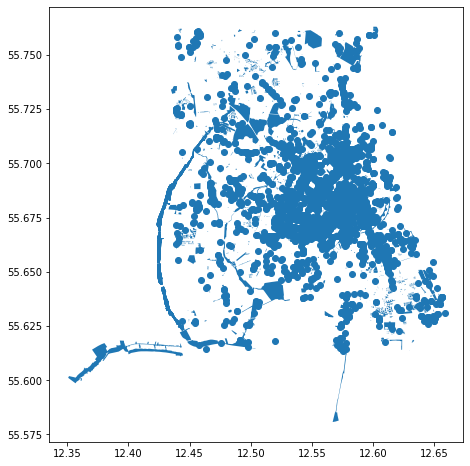

In [31]:
gdf_cph_all.plot()

In [32]:
#Copenhagen
for i in gdf_cph_all["amenity"].unique():
    if i not in keep_list_a:
        print("Amenities that reoccured", i)
        
for i in gdf_cph_all["tourism"].unique():
    if i not in keep_list_t:
        print("Tourism that reoccured", i)
        
for i in gdf_cph_all["leisure"].unique():
    if i not in keep_list_l:
        print("Leisure that reoccured", i)

Amenities that reoccured None
Amenities that reoccured fast_food
Amenities that reoccured bbq
Amenities that reoccured public_bookcase
Amenities that reoccured university
Amenities that reoccured townhall
Tourism that reoccured None
Tourism that reoccured hotel
Tourism that reoccured yes
Leisure that reoccured None
Leisure that reoccured fussball
Leisure that reoccured handicraft
Leisure that reoccured picnic_table


We have looked into each of these manually, and we decide to keep them all since they are 'harmless'

### Making a subset for each category


In [33]:
chill = gdf_cph_all[gdf_cph_all.category=="after_food"]
food = gdf_cph_all[gdf_cph_all.category=="food"]
activity = gdf_cph_all[(gdf_cph_all.category=="outdoor") | (gdf_cph_all.category=="activity") | (gdf_cph_all.category=="cultural")]

len(chill), len(food), len(activity)


(762, 1897, 2853)

In [34]:
print("we end up with \n",len(food), "food places \n", len(chill), "places for relaxing \n", len(activity), "activities \n")


we end up with 
 1897 food places 
 762 places for relaxing 
 2853 activities 



### Change geometry to point if it is not already



In [35]:
# Applying function which changes geometries to be only points
gdf_to_only_points(food)
gdf_to_only_points(chill)
gdf_to_only_points(activity)

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [36]:
# Removing geometry_init because otherwise we cannot save with json
food.drop(['geometry_init'], axis=1, inplace = True)
chill.drop(['geometry_init'], axis=1, inplace = True)
activity.drop(['geometry_init'], axis=1, inplace = True)


/opt/conda/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Converting destinations to nodes in the graph

Later, we want to turn our geocoordinates of locations into OSM IDs.
Ideally, we would be using `osmnx.distance.nearest_nodes`. However, our docker is running an outdated OSMnx version where this function does not work (and its predecessor, ` get_nearest_node`, is deprecated). A possible, neither efficient nor elegant but enough-for-our-purposes workaround is to look for the node that minimizes euclidean distance to the location. 

Note that we still want to plot the destionation at its actual location to ensure that the user is not confused.

**Get coordinates**

In [37]:
# Get coords

food_coords = get_coords_from_gdf(food)
chill_coords = get_coords_from_gdf(chill)
activity_coords = get_coords_from_gdf(activity)

# Add coordinates back into the gdf's
food["coordinates"] = food_coords
chill["coordinates"] = chill_coords
activity["coordinates"] = activity_coords


#### Get nearest OSM ID in the graph

**Food places**

In [39]:
# Converting the desinations coordinates into nodes which exist on our graph
food_node_ids = get_nearest_nodes(food_coords, G)

# Add the information back into the gdf
food["nearest node"] = food_node_ids


**Relaxing destinations (chill)**

In [40]:
# Converting the desinations coordinates into nodes which exist on our graph
chill_node_ids = get_nearest_nodes(chill_coords, G)

# Add the information back into the gdf
chill["nearest node"] = chill_node_ids


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


**Activities**

In [41]:
# Converting the desinations coordinates into nodes which exist on our graph
activity_node_ids = get_nearest_nodes(activity_coords, G)

# Add the information back into the gdf
activity["nearest node"] = activity_node_ids


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


**Plot**

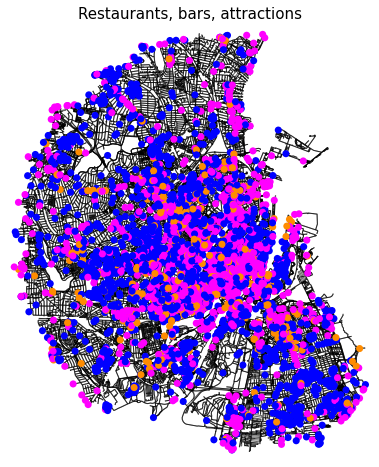

In [42]:

# create node weights 
node_weights = [50 if (node in food_node_ids) or (node in chill_node_ids) or (node in activity_node_ids) else 0 for node in G.nodes]

node_colours = [food_color if node in food_node_ids else chill_color if node in chill_node_ids else activity_color if node in activity_node_ids else 'white' for node in G.nodes]


# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(G, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);

ax.set_title("Restaurants, bars, attractions", fontsize = 15)

plt.savefig('./plots/Copenhagen/food_chill_activities.png')


plt.show()


# Get distance to nearest park/water and get subset

**Get 10 restaurants closest to nature**

In [45]:
food_distances_to_nature, _, food_nearest_nature_type = dist_to_nearest_nature(list(food["coordinates"]), water_subset, parks_subset)

# Apply to gdf
food["dist_to_nature"] = food_distances_to_nature
food["nearest_nature_type"] = food_nearest_nature_type

print("min", min(food_distances_to_nature), "max", max(food_distances_to_nature), "mean", np.mean(food_distances_to_nature))



min 2.1322482167956203e-06 max 0.014043299879916902 mean 0.003092822433397886


**Get 10 bars closest to nature**


In [46]:
chill_distances_to_nature, _, chill_nearest_nature_type = dist_to_nearest_nature(list(chill["coordinates"]), water_subset, parks_subset) # Do it for restaurants etc.

# Apply to gdf
chill["dist_to_nature"] = chill_distances_to_nature
chill["nearest_nature_type"] = chill_nearest_nature_type



**Get 10 attractions closest to nature**


In [47]:
activity_distances_to_nature, _, activity_nearest_nature_type = dist_to_nearest_nature(list(activity["coordinates"]), water_subset, parks_subset) # Do it for restaurants etc.

# Apply to gdf
activity["dist_to_nature"] = activity_distances_to_nature
activity["nearest_nature_type"] = activity_nearest_nature_type



**Get indexes**

If threshold method (only for visualization)

In [48]:
# Threshold method (good for plotting all of Copenhagen, but only for visual purposes)

threshold = 0.0020

#Restaurants 

food_node_ids_nature = np.asarray([i for (i, j) in zip(food_node_ids, food_distances_to_nature) if j < threshold])

print("We go from ", len(food_node_ids), "restaurants to ", len(food_node_ids_nature), "restaurants")

# Bars

chill_node_ids_nature = np.asarray([i for (i, j) in zip(chill_node_ids, chill_distances_to_nature) if j < threshold])


print("We go from ", len(chill_node_ids), "restaurants to ", len(chill_node_ids_nature), "bars")


# Attractions

activity_node_ids_nature = np.asarray([i for (i, j) in zip(activity_node_ids, activity_distances_to_nature) if j < threshold])


print("We go from ", len(activity_node_ids), "restaurants to ", len(activity_node_ids_nature), "attractions")



We go from  1897 restaurants to  714 restaurants
We go from  762 restaurants to  280 bars
We go from  2853 restaurants to  1396 attractions


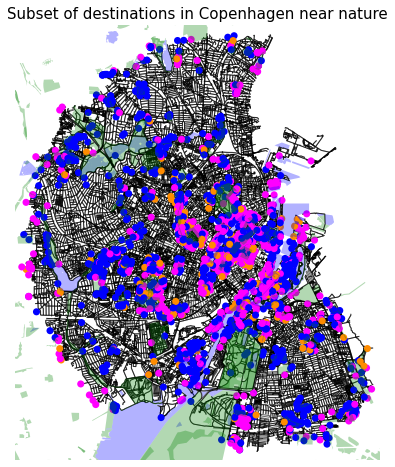

In [49]:

# create node weights 
node_weights = [50 if (node in food_node_ids_nature) or (node in chill_node_ids_nature) or (node in activity_node_ids_nature) else 0 for node in G.nodes]

node_colours = [food_color if node in food_node_ids else chill_color if node in chill_node_ids else activity_color if node in activity_node_ids else 'white' for node in G.nodes]


# Plot

# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(G, node_size=node_weights, node_color = node_colours,  edge_color="black", edge_linewidth=1, edge_alpha=0.6, bgcolor = 'white', show = False, close = False);


water_subset.plot(color="blue", linewidth=1, ax=ax, alpha = 0.3)

parks_subset.plot(color="green", linewidth=1, ax=ax, alpha = 0.3)

ax.set_title("Subset of destinations in Copenhagen near nature", fontsize = 15)

plt.savefig('./plots/Copenhagen/nature_subset_food_chill_activities.png')


plt.show()


**Save food places, relaxing places and activities**


In [50]:
with open('data/geometries/food_destinations.json', 'w') as f:
    f.write(food.to_json())

with open('data/geometries/chill_destinations.json', 'w') as f:
    f.write(chill.to_json())
    
with open('data/geometries/activity_destinations.json', 'w') as f:
    f.write(activity.to_json())   

In [51]:
all_destinations = pd.concat((food, chill))
all_destinations = pd.concat((all_destinations, activity))

In [52]:
with open('data/geometries/destinations_copenhagen_processed.json', 'w') as f:
    f.write(all_destinations.to_json())  
    

# Preprocessing edges

In order to create nicer routes, we create route attributes which encourage the algorithm to choose routes based on other things than just the length of the route. 

We choose to use the following attributes:

- What is the primary use of the road
- What is the speed limit
- Is the edge in a green area?
- Is the edge near water?

### Road use cost

Adding cost which takes into account the use of the road

In [53]:
# Here we look at the possible uses the edges can have, so we get to know our data better

highway_types = []

for u, v, key, data in G.edges(keys=True, data=True): 
    highway_types.append(str(data["highway"]))

highway_list = set(highway_types)
#highway_list

The roads we for all costs want to avoid are:

- 'motorway'
- 'motorway_link'
- 'primary'
- 'primary_link'
- 'trunk'

The roads we would like to avoid are: 

- 'secondary'
- 'secondary_link'
- 'tertiary'
- 'tertiary_link'


In [54]:
# Let's make a function for applying the cost of the road use

no_go_road_types = ['motorway','motorway_link','trunk','primary','primary_link']
unwanted_road_types = ['secondary','secondary_link','tertiary','tertiary_link']


In [55]:
# Let's try to apply it using the function

apply_road_use_cost(G, "use_cost")

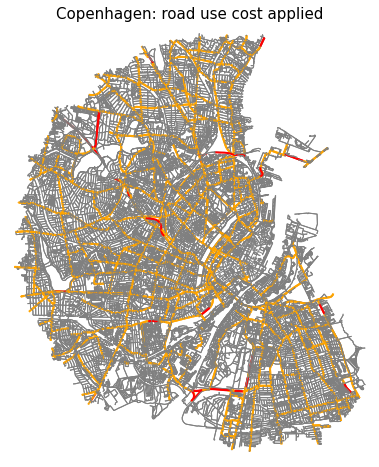

In [56]:
# Let's plot where the highway_cost is over 0 (after applying it)

highway_cost_linewidth = [2 if data["use_cost"] > 0 else 1 for u, v, key, data in G.edges(keys=True, data=True)]
highway_cost_colour = ["r" if data["use_cost"] > 2000 else "orange" if data["use_cost"] > 0 else "grey" for u, v, key, data in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, node_size=0, edge_color=highway_cost_colour, edge_linewidth=highway_cost_linewidth, edge_alpha=1, bgcolor = "white", show = False, close = False)

plt.savefig('./plots/Copenhagen/road_use_cost_applied.png')

ax.set_title("Copenhagen: road use cost applied", fontsize = 15)

plt.show()
    

### Road speed cost

We add an extra cost to roads which scale with the speed limit. The reason we do this, is that the road use cost mostly targets the biggest roads, and in this way we can also target medium roads. But the cost will be smaller now than in the road use cost.

We found that the difficult part here was that sometime the max_speed is listed as a list. This is probably due to the fact that OSMnx sinplifies the network, and that some edge attributes can be concatenated into a list if they are different. We choose to just use the biggest value in the list as the ground truth. 

This is taken care of in our road speed cost function.

In [57]:
# Let's use the function

apply_speed_cost(G, "speed_cost")

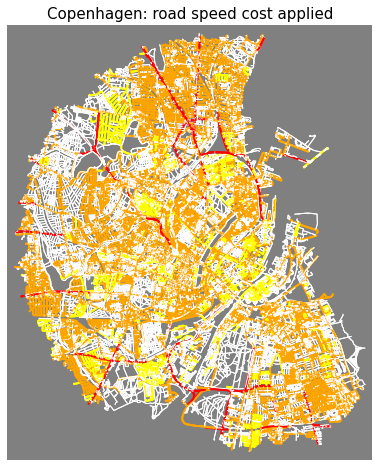

In [58]:
# Let's plot where the speed_cost is over 0 (after applying it)

highway_cost_linewidth = [2 if data["speed_cost"] > 0 else 1 for u, v, key, data in G.edges(keys=True, data=True)]
speed_cost_colour = ["yellow" if (data["speed_cost"] > 0 and data["speed_cost"] < 200) else "orange" if data["speed_cost"] == 200 else "red" if data["speed_cost"] > 50 else "w" for u, v, key, data in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, node_size=0, edge_color=speed_cost_colour, edge_linewidth=highway_cost_linewidth, edge_alpha=1, bgcolor = "grey", show = False, close = False)

plt.savefig('./plots/Copenhagen/speed_use_cost_applied.png')

ax.set_title("Copenhagen: road speed cost applied", fontsize = 15)

plt.show()

### Lower cost for water and green areas



In [59]:
apply_gain_to_edges_in_polygons(G, parks, "park_gain")

In [60]:
apply_gain_to_edges_near_polygons(G, water, "water_gain")

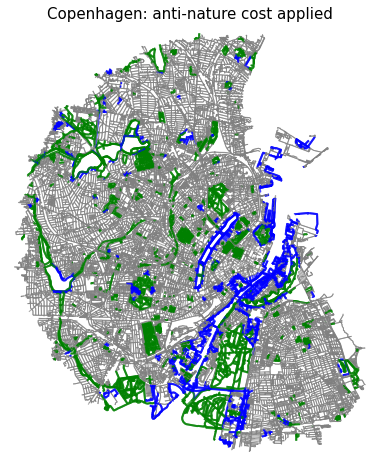

In [61]:
# Let's plot the park and water gain

park_gain_linewidth = [2 if (data["park_gain"] == 0) or (data["water_gain"] == 0) else 1 for u, v, key, data in G.edges(keys=True, data=True)]
park_gain_colour = ["green" if data["park_gain"] == 0 else "blue" if data["water_gain"] == 0 else "grey" for u, v, key, data in G.edges(keys=True, data=True)]

fig, ax = ox.plot_graph(G, node_size=0, edge_color=park_gain_colour, edge_linewidth=park_gain_linewidth, edge_alpha=0.7, bgcolor = "white", show = False, close = False)

ax.set_title("Copenhagen: anti-nature cost applied", fontsize = 15)


plt.savefig('./plots/Copenhagen/park_water_gain_cost_applied.png')
    
plt.show()


### Adding all the edge attributes together

In [62]:
attributes = ['length', 'use_cost', 'speed_cost', 'park_gain', 'water_gain']


In [63]:
list_total_costs = sum_edge_attributes(G, attributes)


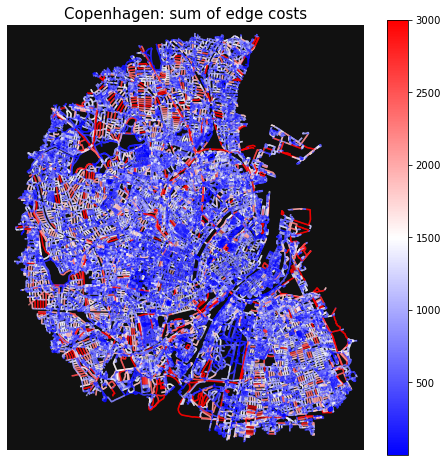

In [64]:
# Making colour scale
norm = matplotlib.colors.Normalize(vmin=min(list_total_costs), vmax=3000)
cmap = cm.bwr
m = cm.ScalarMappable(norm=norm, cmap=cmap)

edge_cost_colors = [m.to_rgba(data["total_cost"]) for u, v, key, data in G.edges(keys=True, data=True)]

# Plotting the figure
    
fig, ax = ox.plot_graph(G, node_size=0, edge_color=edge_cost_colors, edge_linewidth=1.5, edge_alpha=0.7,show=False, close=False)

fig.colorbar(m, ax = ax, orientation='vertical')

ax.set_title("Copenhagen: sum of edge costs", fontsize = 15)


plt.show()

# Save graph with new edge weights

In [69]:
## Import graph data from folder

ox.io.save_graphml(G, "./data/graphs/G_copenhagen_preprocessed")
